# HESG Data usage - 4 - occupier heating schedule

## Introduction

This notebook is part of the HESG Data Usage package. Please refer to the whole repository available here:  
https://gitlab.com/es-catapult-ds/hesg-data-examples

Please refer to this repository for the license, python packages requirement and how to access data.

## Content of this notebook

This notebook shows an example of how access and use the HESG Data to display the requested temperature by the occupiers. This can be using the userheatingschedule (weekly preference for each room), or using the useroverrides (occasional heat request).

It is assumed that the following files are in the working directory:
- eden1useroverrides.csv
- eden1heatingtargets.csv
- eden1homemodel.csv
- eden1userheatingschedule.csv

## 1. Import the libraries

In [1]:
# CSV files are loaded with pandas
import pandas as pd

# plotting is done with matplotlib
import matplotlib.pyplot as plt
# this jupyter notebook command enables interactive plotting
%matplotlib notebook
# remove SettingWithCopyWarning warning message to avoid distraction
pd.set_option('mode.chained_assignment', None)

## 2. Load the useroverrides

The occupier can do occasional/temporary changes to the heat request without having to redefine the whole weekly schedule. Those changes are called "overrides".

In [3]:
df_uo = pd.read_csv("./eden1useroverrides.csv")
# display the content of the table
# for illustration only
df_uo

houseid                                             roomid  \
0          31  2a19771dbb32d06a08454654c7dac2fcc38ae3aa5861f7...   
1          31  2a19771dbb32d06a08454654c7dac2fcc38ae3aa5861f7...   
2          31  2a19771dbb32d06a08454654c7dac2fcc38ae3aa5861f7...   
3          31  2a19771dbb32d06a08454654c7dac2fcc38ae3aa5861f7...   
4          31  2a19771dbb32d06a08454654c7dac2fcc38ae3aa5861f7...   
...       ...                                                ...   
4237      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
4238      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
4239      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
4240      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
4241      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   

                         starttime  active duration  \
0     2018-10-16 11:56:18.000+0000   False      NaN   
1     2018-10-16 12:05:51.000+0000   False      NaN   
2     2019-02-05 12:28:25.000+0000   False      NaN   
3     2019-02-21 13:06:29.000+0000   False      NaN   
4     2019-02-21 16:19:44.000+0000   False      NaN   
...                            ...     ...      ...   
4237  2019-06-06 19:32:54.000+0000   False    timed   
4238  2019-06-06 19:33:08.000+0000   False    timed   
4239  2019-06-06 19:33:08.000+0000    True    timed   
4240  2019-06-10 19:16:50.000+0000   False    timed   
4241  2019-06-10 19:16:50.000+0000    True    timed   

                           endtime  increment                   lastupdated  \
0     2028-10-13 11:56:18.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1     2028-10-13 12:05:51.000+0000        NaN  2019-10-29 13:18:20.000+0000   
2     2029-02-02 12:28:25.000+0000        NaN  2019-10-29 13:18:20.000+0000   
3     2029-02-18 13:06:29.000+0000        NaN  2019-10-29 13:18:20.000+0000   
4     2029-02-18 16:19:44.000+0000        NaN  2019-10-29 13:18:20.000+0000   
...                            ...        ...                           ...   
4237  2019-06-06 20:32:52.000+0000        NaN  2019-10-29 13:18:20.000+0000   
4238  2019-06-06 20:33:06.000+0000        NaN  2019-10-29 13:18:20.000+0000   
4239  2019-06-06 20:33:06.000+0000        NaN  2019-10-29 13:18:20.000+0000   
4240  2019-06-10 20:16:48.000+0000        NaN  2019-10-29 13:18:20.000+0000   
4241  2019-06-10 20:16:48.000+0000        NaN  2019-10-29 13:18:20.000+0000   

      max  min operation         overridetype  previoustargetmax  \
0      10    5       NaN              suspend                 10   
1      10    5       NaN              suspend                 10   
2      10    5       NaN              suspend                 10   
3      10    5       NaN              suspend                 10   
4      10    5       NaN              suspend                 10   
...   ...  ...       ...                  ...                ...   
4237   22   20       NaN  discomfort_feedback                 21   
4238   23   21       NaN  discomfort_feedback                 21   
4239   23   21   warming  discomfort_feedback                 21   
4240   23   21       NaN  discomfort_feedback                 21   
4241   23   21   warming  discomfort_feedback                 21   

      previoustargetmin recurs  simulationtime  
0                     5   once             NaN  
1                     5   once             NaN  
2                     5   once             NaN  
3                     5   once             NaN  
4                     5   once             NaN  
...                 ...    ...             ...  
4237                 19   once             NaN  
4238                 19   once             NaN  
4239                 19   once             NaN  
4240                 19   once             NaN  
4241                 19   once       59.895963  

[4242 rows x 16 columns]

In [4]:
# select a specific house id
df_uo = df_uo[df_uo["houseid"] == 76]

In [5]:
# the room id are translated into a more human-readable format.
df_homemodel = pd.read_csv("./eden1homemodel.csv")
df_homemodel = df_homemodel[df_homemodel["houseid"] == 76]
df_rooms = df_homemodel.groupby("roomname").first()
df_rooms["roomtype_indice"] = df_rooms.groupby("roomtype").cumcount()
df_rooms["roomname2"] = (df_rooms["roomtype"].astype(str).str.replace(" & ", "")
                         + df_rooms["roomtype_indice"].astype(str))
df_rooms = df_rooms[["roomname2"]]
df_uo["roomid"] = df_uo["roomid"].replace(df_rooms["roomname2"].to_dict())

In [6]:
# how many overrides for each rooms
# for illustration only
df_uo.groupby("roomid").count()["houseid"]

roomid
Bathrooms0                                                            9
Bathrooms1                                                            6
Bathrooms2                                                            5
Bedrooms0                                                            25
Bedrooms1                                                            37
Bedrooms2                                                            14
Bedrooms3                                                            36
Default0                                                             10
Default1                                                            506
KitchenDining0                                                        5
Lounge0                                                             263
Storage Rooms0                                                        6
e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aacf8ddd5949332de98f     24
Name: houseid, dtype: int64

"e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aacf8ddd5949332de98f" is the "empty" room.

The overrides that are associated to the "empty" room are always "suspend the heating", and are therefore not linked to a particular room.

In [7]:
# display those
# for illustration only
df_uo[df_uo["roomid"] == "e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aacf8ddd5949332de98f"]

houseid                                             roomid  \
1683       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1684       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1685       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1686       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1687       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1688       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1689       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1690       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1691       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1692       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1693       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1694       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1695       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1696       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1697       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1698       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1699       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1700       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1701       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1702       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1703       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1704       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1705       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   
1706       76  e7488d133d4fe8398ae4c29b89819e7f324ad0483b47aa...   

                         starttime  active duration  \
1683  2018-10-17 15:07:01.000+0000   False      NaN   
1684  2018-11-11 08:10:07.000+0000   False      NaN   
1685  2018-12-29 10:40:17.000+0000   False      NaN   
1686  2019-04-16 13:30:04.000+0000   False      NaN   
1687  2019-04-25 07:51:05.000+0000   False      NaN   
1688  2019-04-25 08:42:35.000+0000   False      NaN   
1689  2019-04-26 08:31:46.000+0000   False      NaN   
1690  2019-04-26 12:12:08.000+0000   False      NaN   
1691  2019-04-26 12:38:35.000+0000   False      NaN   
1692  2019-05-14 08:12:39.000+0000   False      NaN   
1693  2019-05-16 08:16:10.000+0000   False      NaN   
1694  2019-05-30 08:26:23.000+0000   False      NaN   
1695  2019-06-06 08:20:53.000+0000   False      NaN   
1696  2019-06-07 08:57:50.000+0000   False      NaN   
1697  2019-06-10 08:23:36.000+0000   False      NaN   
1698  2019-06-18 08:09:39.000+0000   False      NaN   
1699  2019-06-26 18:17:37.000+0000   False      NaN   
1700  2019-07-08 08:07:09.000+0000   False      NaN   
1701  2019-08-20 18:25:08.000+0000   False      NaN   
1702  2019-08-30 17:01:37.000+0000   False      NaN   
1703  2019-09-09 08:49:53.000+0000   False      NaN   
1704  2019-09-09 16:04:12.000+0000   False      NaN   
1705  2019-09-10 08:10:13.000+0000   False      NaN   
1706  2019-09-28 16:19:07.000+0000   False      NaN   

                           endtime  increment                   lastupdated  \
1683  2028-10-14 15:07:01.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1684  2028-11-08 08:10:07.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1685  2028-12-26 10:40:17.000+0000        NaN  2019-10-29 13:18:19.000+0000   
1686  2029-04-13 13:30:04.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1687  2029-04-22 07:51:05.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1688  2029-04-22 08:42:35.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1689  2029-04-23 08:31:46.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1690  2029-04-23 12:12:08.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1691  2029-04-23 12:38:35.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1692  2029-05-11 08:12:39.000+0000        NaN  2019-10-29 13:18:20.000+0000   
1693  2029-05-13 08:16:10.000+0000        NaN  2019-10-29 13

They are set for "10 years" and stop when the user manually desactivate them.

Unfortunately, the table does not contain the information of when they are disactivated (lastupdated is not correct).

In [8]:
# let's look at bedrooms0
df_uo[df_uo["roomid"] == "Bedrooms0"]

houseid     roomid                     starttime  active duration  \
761       76  Bedrooms0  2018-10-16 18:20:31.000+0000   False    timed   
762       76  Bedrooms0  2018-10-16 18:20:31.000+0000    True    timed   
763       76  Bedrooms0  2018-10-16 18:20:36.000+0000   False    timed   
764       76  Bedrooms0  2018-10-16 18:20:36.000+0000    True    timed   
765       76  Bedrooms0  2018-10-27 14:12:13.000+0000   False    timed   
766       76  Bedrooms0  2018-10-27 14:12:13.000+0000    True    timed   
767       76  Bedrooms0  2018-10-28 19:44:47.000+0000   False    timed   
768       76  Bedrooms0  2018-10-28 19:45:05.000+0000   False    timed   
769       76  Bedrooms0  2018-10-28 19:45:15.000+0000   False    timed   
770       76  Bedrooms0  2018-10-28 19:45:40.000+0000   False    timed   
771       76  Bedrooms0  2018-10-28 19:45:40.000+0000    True    timed   
772       76  Bedrooms0  2018-11-04 19:51:40.000+0000   False    timed   
773       76  Bedrooms0  2018-11-04 19:51:40.000+0000    True    timed   
774       76  Bedrooms0  2018-11-10 20:01:09.000+0000   False    timed   
775       76  Bedrooms0  2018-11-10 20:01:09.000+0000    True    timed   
776       76  Bedrooms0  2018-12-07 18:41:54.000+0000   False    timed   
777       76  Bedrooms0  2018-12-07 18:41:54.000+0000    True    timed   
778       76  Bedrooms0  2018-12-31 08:30:44.000+0000   False    timed   
779       76  Bedrooms0  2018-12-31 08:31:08.000+0000   False    timed   
780       76  Bedrooms0  2018-12-31 08:31:08.000+0000    True    timed   
781       76  Bedrooms0  2019-01-25 20:11:50.000+0000   False    timed   
782       76  Bedrooms0  2019-01-28 15:27:54.000+0000   False    timed   
783       76  Bedrooms0  2019-01-28 15:27:54.000+0000    True    timed   
784       76  Bedrooms0  2019-09-09 15:55:52.000+0000   False    timed   
785       76  Bedrooms0  2019-09-09 15:55:52.000+0000    True    timed   

                          endtime  increment                   lastupdated  \
761  2018-10-16 19:15:29.000+0000        NaN  2019-10-29 13:18:20.000+0000   
762  2018-10-16 19:15:29.000+0000        NaN  2019-10-29 13:18:20.000+0000   
763  2018-10-16 19:15:34.000+0000        NaN  2019-10-29 13:18:20.000+0000   
764  2018-10-16 19:15:34.000+0000        NaN  2019-10-29 13:18:20.000+0000   
765  2018-10-27 15:12:13.000+0000        NaN  2019-10-29 13:18:20.000+0000   
766  2018-10-27 15:12:13.000+0000        NaN  2019-10-29 13:18:20.000+0000   
767  2018-10-28 20:45:45.000+0000        NaN  2019-10-29 13:18:20.000+0000   
768  2018-10-28 20:15:02.000+0000        NaN  2019-10-29 13:18:20.000+0000   
769  2018-10-28 20:45:13.000+0000        NaN  2019-10-29 13:18:20.000+0000   
770  2018-10-28 20:15:37.000+0000        NaN  2019-10-29 13:18:20.000+0000   
771  2018-10-28 20:15:37.000+0000        NaN  2019-10-29 13:18:20.000+0000   
772  2018-11-04 20:51:40.000+0000        NaN  2019-10-29 13:18:20.000+0000   
773  2018-11-04 20:51:40.000+0000        NaN  2019-10-29 13:18:20.000+0000   
774  2018-11-10 21:00:07.000+0000        NaN  2019-10-29 13:18:20.000+0000   
775  2018-11-10 21:00:07.000+0000        NaN  2019-10-29 13:18:20.000+0000   
776  2018-12-07 19:45:52.000+0000        NaN  2019-10-29 13:18:20.000+0000   
777  2018-12-07 19:45:52.000+0000        NaN  2019-10-29 13:18:20.000+0000   
778  2018-12-31 09:30:42.000+0000        NaN  2019-10-29 13:18:19.000+0000   
779  2018-12-31 09:30:06.000+0000        NaN  2019-10-29 13:18:19.000+0000   
780  2018-12-31 09:30:06.000+0000        NaN  2019-10-29 13:18:19.000+0000   
781  2019-01-25 21:11:50.000+0000        NaN  2019-10-29 13:18:20.000+0000   
782  2019-01-28 16:27:54.000+0000        NaN  2019-10-29 13:18:20.000+0000   
783  2019-01-28 16:27:54.000+0000        NaN  2019-10-29 13:18:20.000+0000   
784  2019-09-09 16:55:50.000+0000        NaN  2019-10-29 13:18:20.000+0000   
785  2019-09-09 16:55:50.000+0000        NaN  2019-10-29 13:18:20.000+0000   

     max  min    operation         overridetype  pr

override types are "heat burst", "laundry dry" and "discomford feedback"

- "heat burst" and "laundry dry" are setting the target temperature to a high temperature (24 degrees) for a given period of time (1 hour).

- "discomfort feedback" is when the occupier want to move the current target temperature up or down by few degrees.

You can notice that some have "active" == False: the occupier has canceled the override. Unfortunately, we do not know when.

You can also notice that some seems to be duplicated: this is due to how the overrides are created. (in particular: a first document is created, triggering the creation of a second document with the predicted heating time).

If the occupier want to move the current target temperature from 20 to 24 degree, the occupier will have to click on the "+1 degree" button four times, which will create 4 different override rows created at almost the saame time, the last one specifying a target temperature of 24 degree and override the previous ones.

We don't know the exact time of an override, but we have the heating targets. The useroverrides will inform us of the reason of some target bands in the heating targets.

## 3. Comparison between useroverrides and heatingtargets

The heating targets correspond to what really happened. When an override occurs, it is visible in the heating targets.

The heating targets are explained in details in the previous notebook.

In [9]:
# load the heating targets
df_heatingtargets = pd.read_csv("./eden1heatingtargets.csv")
# select the house id
df_ht_selected = df_heatingtargets[df_heatingtargets["houseid"] == 76]
# rename the room id
df_ht_selected["roomid"] = df_ht_selected["roomid"].replace(df_rooms["roomname2"].to_dict())
df_ht_selected = df_ht_selected[df_ht_selected["roomid"] == "Bedrooms0"]
# convert the timestamp to Datetime
df_ht_selected["timestamp"] = pd.to_datetime(df_ht_selected["timestamp"])
# set the empty pseudo-targets to
df_ht_selected["psmax"] = df_ht_selected["psmax"].fillna(10)
df_ht_selected["psmin"] = df_ht_selected["psmin"].fillna(5)

Let's look at 28/01.

There is a "heat burst" (short request for high heat).

If we plot the target for this period, we can indeed see that for the given period, the target temperature band jumps to 24 degree.

<IPython.core.display.Javascript object>


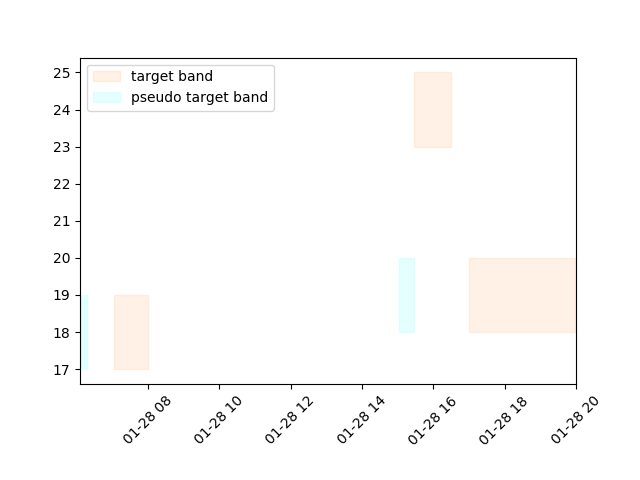

In [10]:
period = ["28 Jan 2019", "29 Jan 2019"]
df2 = df_ht_selected.copy()
df2 = df2[(df2["timestamp"] >= period[0]) 
        & (df2["timestamp"] < period[1])]
df2 = df2.set_index("timestamp")
df2 = df2.resample("1min").max().fillna(method="ffill")
df2 = df2.replace({5:None, 10: None})
plt.close()
plt.fill_between(df2.index, df2["min"], df2["max"],
            alpha=0.1, color="tab:orange", label="target band")
plt.fill_between(df2.index, df2["psmin"], df2["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band")
plt.xticks(rotation=45)
plt.xlim([df2.index.min(), df2.index.max()])
plt.subplots_adjust(bottom=0.2)
plt.legend(loc="upper left")

Let's look at 07/12.

There is a "discomfort feedback" (short request for slightly higher or slightly lower target).

If we plot the target for this period, we can indeed see that for the given period, the target temperature band has been increased by 1 degree.

<IPython.core.display.Javascript object>


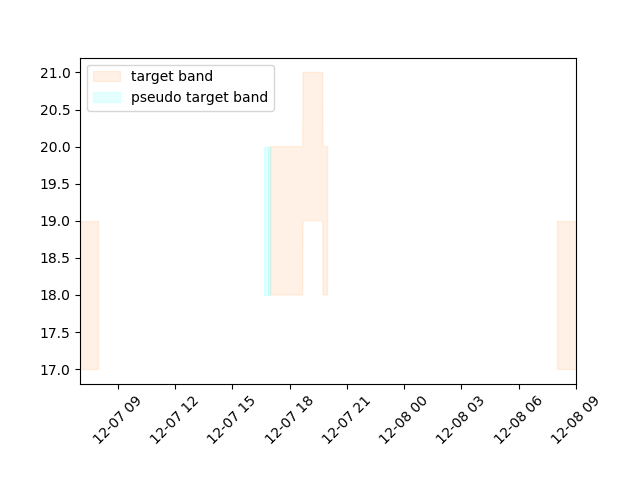

In [11]:
# let's look at 07/12 (discomfort feedback)
period = ["7 Dec 2018", "8 Dec 2018 10:00"]
df2 = df_ht_selected.copy()
df2 = df2[(df2["timestamp"] >= period[0]) 
        & (df2["timestamp"] < period[1])]
df2 = df2.set_index("timestamp")
df2 = df2.resample("1min").max().fillna(method="ffill")
df2 = df2.replace({5:None, 10: None})
plt.close()
plt.fill_between(df2.index, df2["min"], df2["max"],
            alpha=0.1, color="tab:orange", label="target band")
plt.fill_between(df2.index, df2["psmin"], df2["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band")
plt.xticks(rotation=45)
plt.xlim([df2.index.min(), df2.index.max()])
plt.subplots_adjust(bottom=0.2)
plt.legend(loc="upper left")

## 4. Load the user heating schedule

This table contains the weekly target temperatures for each room for each hour.

In [12]:
df_uhs = pd.read_csv("./eden1userheatingschedule.csv")
# display the content of the table
# for illustration only
df_uhs

houseid                                             roomid  hour  \
0             63  1365a3655ac0ddf8d5f381eabf2703ca95d2389a3a6564...     0   
1             63  1365a3655ac0ddf8d5f381eabf2703ca95d2389a3a6564...     0   
2             63  1365a3655ac0ddf8d5f381eabf2703ca95d2389a3a6564...     0   
3             63  1365a3655ac0ddf8d5f381eabf2703ca95d2389a3a6564...     0   
4             63  1365a3655ac0ddf8d5f381eabf2703ca95d2389a3a6564...     0   
...          ...                                                ...   ...   
2792659      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...    23   
2792660      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...    23   
2792661      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...    23   
2792662      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...    23   
2792663      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...    23   

               day          createdtimestamp  active   daytype  max  min  
0           FRIDAY  2017-12-21T14:56:00+0000    True      work   10    5  
1           MONDAY  2017-12-21T14:56:00+0000    True      work   10    5  
2         SATURDAY  2017-12-21T14:56:00+0000    True      rest   10    5  
3           SUNDAY  2017-12-21T14:56:00+0000    True      rest   10    5  
4         THURSDAY  2017-12-21T14:56:00+0000    True      work   10    5  
...            ...                       ...     ...       ...  ...  ...  
2792659  WEDNESDAY  2019-10-01T20:52:18+0100    True  Away Day   10    5  
2792660  WEDNESDAY  2019-10-01T20:54:38+0100    True  Away Day   10    5  
2792661  WEDNESDAY  2019-10-01T20:54:54+0100    True  Away Day   10    5  
2792662  WEDNESDAY  2019-10-01T20:55:06+0100    True  Away Day   10    5  
2792663  WEDNESDAY  2019-10-01T20:55:19+0100    True  Away Day   10    5  

[2792664 rows x 9 columns]

In [13]:
# select one specific house
df_uhs = df_uhs[df_uhs["houseid"] == 76]
# display the number of row for each different user heating schedule
# for illustration only
df_uhs.groupby("createdtimestamp").count()["houseid"][-40:]

createdtimestamp
2018-03-27T15:25:49+0100    2016
2018-03-27T15:29:21+0100    2016
2018-03-27T16:05:02+0100    2016
2018-03-29T16:41:46+0100    2016
2018-03-29T16:52:11+0100    2016
2018-05-12T07:38:37+0100    2016
2018-11-24T08:38:44+0000    2016
2018-11-25T15:49:05+0000    2016
2018-12-16T08:42:53+0000    2016
2018-12-16T08:42:57+0000    2016
2018-12-16T08:43:03+0000    2016
2018-12-16T08:45:54+0000    2016
2018-12-16T08:46:26+0000    2016
2018-12-16T08:47:45+0000    2016
2018-12-16T08:48:13+0000    2016
2018-12-16T08:49:52+0000    2016
2018-12-16T08:50:28+0000    2016
2018-12-22T11:49:25+0000    2016
2018-12-22T11:50:09+0000    2016
2018-12-22T11:50:32+0000    2016
2018-12-22T11:50:33+0000    2016
2018-12-22T11:51:21+0000    2016
2018-12-22T11:51:22+0000    2016
2018-12-22T11:52:17+0000    2016
2018-12-22T11:52:18+0000    2016
2018-12-24T21:24:06+0000    2016
2018-12-26T09:53:12+0000    2016
2018-12-26T09:53:13+0000    2016
2019-01-01T08:23:16+0000    2016
2019-01-01T08:25:35+0000  

As visible, there are several set of user heating schedule for different timestamp: each time the occupier redefines the heating schedule, a complete schedule is created.

Each schedule has, in this case, 2016 rows: one row per each hour of the week (24 * 7), multiplied by 12 because this specific house has 12 controlled rooms in which the occupier can define a specific schedule. 24 * 7 * 12 = 2016.

In [14]:
# display one specific heating schedule
# for illustration only
df_uhs[(df_uhs["createdtimestamp"] == "2018-12-22T11:52:18+0000")]

houseid                                             roomid  hour  \
6356          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
6552          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
6748          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
6944          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
7140          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
...          ...                                                ...   ...   
1782240       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   
1782436       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   
1782632       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   
1782828       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   
1784024       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   

               day          createdtimestamp  active     daytype  max  min  
6356        FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
6552        MONDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
6748      SATURDAY  2018-12-22T11:52:18+0000    True  W/e + Weds   10    5  
6944        SUNDAY  2018-12-22T11:52:18+0000    True  W/e + Weds   10    5  
7140      THURSDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
...            ...                       ...     ...         ...  ...  ...  
1782240   SATURDAY  2018-12-22T11:52:18+0000   False  W/e + Weds   10    5  
1782436     SUNDAY  2018-12-22T11:52:18+0000   False  W/e + Weds   10    5  
1782632   THURSDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1782828    TUESDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1784024  WEDNESDAY  2018-12-22T11:52:18+0000   False  W/e + Weds   10    5  

[2016 rows x 9 columns]

There is 2016 rows: 24 * 7 * 12

In [15]:
# display one specific day (friday) of one specific heating schedule
# for illustration only
df_uhs[(df_uhs["createdtimestamp"] == "2018-12-22T11:52:18+0000") & (df_uhs["day"] == "FRIDAY")]

houseid                                             roomid  hour  \
6356          76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
12728         76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     1   
19100         76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     2   
29472         76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     3   
35844         76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     4   
...          ...                                                ...   ...   
1760360       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    19   
1764732       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    20   
1771104       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    21   
1774476       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    22   
1778848       76  d45599929e58df4b177cf44415678fec6229bbbd4b06a6...    23   

            day          createdtimestamp  active     daytype  max  min  
6356     FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
12728    FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
19100    FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
29472    FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
35844    FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
...         ...                       ...     ...         ...  ...  ...  
1760360  FRIDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1764732  FRIDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1771104  FRIDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1774476  FRIDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  
1778848  FRIDAY  2018-12-22T11:52:18+0000   False  Clinic_day   10    5  

[288 rows x 9 columns]

There is 288 rows: 24 * 12

In [16]:
df_uhs[(df_uhs["createdtimestamp"] == "2018-12-22T11:52:18+0000")
       & (df_uhs["day"] == "FRIDAY")
       & (df_uhs["roomid"] == "10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6e48b8af6e0a4d70f89")]

houseid                                             roomid  hour  \
6356         76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     0   
12728        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     1   
19100        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     2   
29472        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     3   
35844        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     4   
47216        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     5   
53588        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     6   
59960        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     7   
72332        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     8   
78704        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...     9   
85076        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    10   
96448        76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    11   
102820       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    12   
114192       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    13   
120564       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    14   
126936       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    15   
138308       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    16   
144680       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    17   
151052       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    18   
162424       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    19   
168796       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    20   
175168       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    21   
185540       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    22   
190912       76  10fde831cde6ad37a7c703e93ff5df339803b543d0b5b6...    23   

           day          createdtimestamp  active     daytype  max  min  
6356    FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
12728   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
19100   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
29472   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
35844   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
47216   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
53588   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
59960   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   19   17  
72332   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
78704   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
85076   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
96448   FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
102820  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
114192  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
120564  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
126936  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
138308  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
144680  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   20   18  
151052  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   20   18  
162424  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   20   18  
168796  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
175168  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
185540  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5  
190912  FRIDAY  2018-12-22T11:52:18+0000    True  Clinic_day   10    5

There is 24 rows, one for each hour of the day

In [17]:
# the room id are translated into a more human-readable format.
df_uhs["roomid"] = df_uhs["roomid"].replace(df_rooms["roomname2"].to_dict())

The occupier can change temperature in every rooms having a radiator_box
 (even if this radiator does not have a wireless radiator valve).

In [18]:
# display the room id in the schedule
# for illustration only
df_uhs["roomid"].drop_duplicates().sort_values()

576288         Bathrooms0
874544         Bathrooms1
1528184        Bathrooms2
6176            Bedrooms0
197104          Bedrooms1
1010472         Bedrooms2
1143400         Bedrooms3
1276328          Default0
1403256          Default1
1659112    KitchenDining0
740408            Lounge0
390032     Storage Rooms0
Name: roomid, dtype: object

In [19]:
# display the rooms that contain a radiator box, using the homemodel data
df_homemodel["roomname"] =  df_homemodel["roomname"].replace(df_rooms["roomname2"].to_dict())
df_homemodel[df_homemodel["sensortype"] == "RADIATOR_BOX"]["roomname"].drop_duplicates().sort_values()

183        Bathrooms0
181        Bathrooms1
185        Bathrooms2
188         Bedrooms0
186         Bedrooms1
189         Bedrooms2
187         Bedrooms3
177          Default0
182          Default1
179    KitchenDining0
178           Lounge0
190    Storage Rooms0
Name: roomname, dtype: object

In [20]:
# display the rooms that contain a wireless radiator valve, using the homemodel data
df_homemodel[df_homemodel["sensortype"] == "WIRELESS_RADIATOR_VALVE"]["roomname"].drop_duplicates().sort_values()

210        Bathrooms0
208        Bathrooms1
213         Bedrooms0
211         Bedrooms1
214         Bedrooms2
212         Bedrooms3
204          Default0
209          Default1
206    KitchenDining0
205           Lounge0
215    Storage Rooms0
Name: roomname, dtype: object

As visible, the room named "Bathrooms2" does not contain a wireless radiator valve, but is still present in the schedule list, because in HESG, an occupier can still set a specific schedule for this room (the heating will be regulated using adjacent controlled rooms).

## 5. Plot the schedule for one room for one time period starting a Monday

If we want to know the schedule of the week of the Monday 4th March 2019, the latest created userheatingschedule before this date is the one of the 28th Jan.

The selected room is Bedrooms0.

In [21]:
# select the correct schedule (the last modification applying to this date is the modification of the 28 Jan)
df_uhs_march = df_uhs[df_uhs["createdtimestamp"] == "2019-01-28T18:03:29+0000"]
# let's just look at Bedrooms0
df_uhs_march = df_uhs_march[df_uhs_march["roomid"] == "Bedrooms0"]
# display the table
# for illustration only
df_uhs_march

houseid     roomid  hour        day          createdtimestamp  active  \
6367         76  Bedrooms0     0     FRIDAY  2019-01-28T18:03:29+0000    True   
6563         76  Bedrooms0     0     MONDAY  2019-01-28T18:03:29+0000    True   
6759         76  Bedrooms0     0   SATURDAY  2019-01-28T18:03:29+0000    True   
6955         76  Bedrooms0     0     SUNDAY  2019-01-28T18:03:29+0000    True   
7151         76  Bedrooms0     0   THURSDAY  2019-01-28T18:03:29+0000    True   
...         ...        ...   ...        ...                       ...     ...   
196315       76  Bedrooms0    23   SATURDAY  2019-01-28T18:03:29+0000    True   
196511       76  Bedrooms0    23     SUNDAY  2019-01-28T18:03:29+0000    True   
196707       76  Bedrooms0    23   THURSDAY  2019-01-28T18:03:29+0000    True   
196903       76  Bedrooms0    23    TUESDAY  2019-01-28T18:03:29+0000    True   
197099       76  Bedrooms0    23  WEDNESDAY  2019-01-28T18:03:29+0000    True   

           daytype  max  min  
6367    Clinic_day   10    5  
6563    Clinic_day   10    5  
6759    W/e + Weds   10    5  
6955    W/e + Weds   10    5  
7151    Clinic_day   10    5  
...            ...  ...  ...  
196315  W/e + Weds   10    5  
196511  W/e + Weds   10    5  
196707  Clinic_day   10    5  
196903  Clinic_day   10    5  
197099  W/e + Weds   10    5  

[168 rows x 9 columns]

In [22]:
# let's replace Monday by 0, Tuesday by 24, Wednesday by 48, ...
hours = {month: i*24 for i, month in enumerate(["MONDAY", 
                                                "TUESDAY",
                                               "WEDNESDAY",
                                               "THURSDAY",
                                               "FRIDAY",
                                               "SATURDAY",
                                               "SUNDAY"])}
df_uhs_march["hour_day"] = df_uhs_march["day"].replace(hours)
df_uhs_march

houseid     roomid  hour        day          createdtimestamp  active  \
6367         76  Bedrooms0     0     FRIDAY  2019-01-28T18:03:29+0000    True   
6563         76  Bedrooms0     0     MONDAY  2019-01-28T18:03:29+0000    True   
6759         76  Bedrooms0     0   SATURDAY  2019-01-28T18:03:29+0000    True   
6955         76  Bedrooms0     0     SUNDAY  2019-01-28T18:03:29+0000    True   
7151         76  Bedrooms0     0   THURSDAY  2019-01-28T18:03:29+0000    True   
...         ...        ...   ...        ...                       ...     ...   
196315       76  Bedrooms0    23   SATURDAY  2019-01-28T18:03:29+0000    True   
196511       76  Bedrooms0    23     SUNDAY  2019-01-28T18:03:29+0000    True   
196707       76  Bedrooms0    23   THURSDAY  2019-01-28T18:03:29+0000    True   
196903       76  Bedrooms0    23    TUESDAY  2019-01-28T18:03:29+0000    True   
197099       76  Bedrooms0    23  WEDNESDAY  2019-01-28T18:03:29+0000    True   

           daytype  max  min  hour_day  
6367    Clinic_day   10    5        96  
6563    Clinic_day   10    5         0  
6759    W/e + Weds   10    5       120  
6955    W/e + Weds   10    5       144  
7151    Clinic_day   10    5        72  
...            ...  ...  ...       ...  
196315  W/e + Weds   10    5       120  
196511  W/e + Weds   10    5       144  
196707  Clinic_day   10    5        72  
196903  Clinic_day   10    5        24  
197099  W/e + Weds   10    5        48  

[168 rows x 10 columns]

In [23]:
# let's create a datetime column
# 1) start with the initial time
df_uhs_march["datetime"] = pd.Timestamp("4 Mar 2019")
# 2) get the hours that we want to add
df_uhs_march["total_hours"] = df_uhs_march["hour"] + df_uhs_march["hour_day"]
# 3) change the integer into a Timedelta
df_uhs_march["total_hours"] = df_uhs_march["total_hours"].apply(lambda x: pd.Timedelta(hours=x))
# 4) add the timedelta to "datetime"
df_uhs_march["datetime"] = df_uhs_march["datetime"] + df_uhs_march["total_hours"]
df_uhs_march = df_uhs_march.sort_values("datetime")

<IPython.core.display.Javascript object>


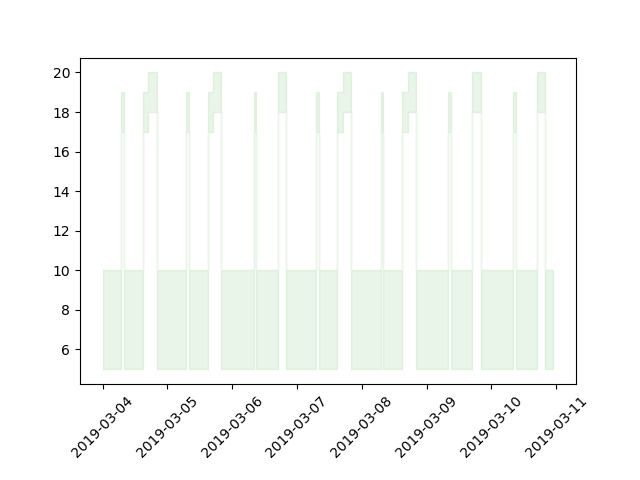

In [24]:
plt.close()
plt.fill_between(df_uhs_march["datetime"], df_uhs_march["min"], df_uhs_march["max"],
            alpha=0.1, color="tab:green", label="user heating schedule", step="post")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.2)

## 6. Comparison between userheatingschedule and heatingtargets

The heating targets correspond to what really happened. The userheatingschedule corrsponds to the target without accounting for the pre-heating and the user overrides.

<IPython.core.display.Javascript object>


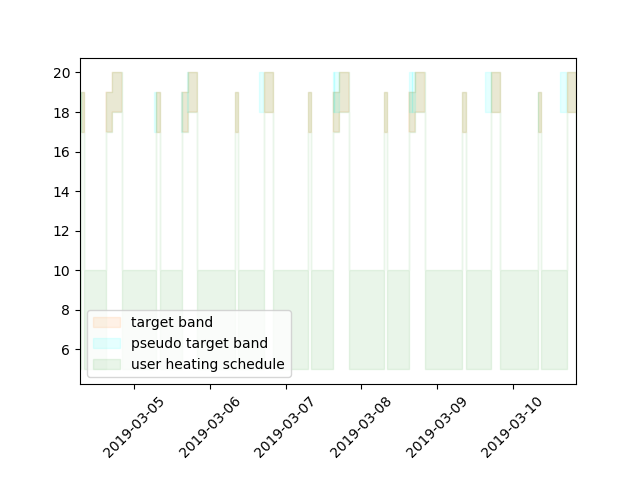

In [25]:
period = ["4 Mar 2019", "11 Mar 2019"]
df2 = df_ht_selected.copy()
df2 = df2[(df2["timestamp"] >= period[0]) 
        & (df2["timestamp"] < period[1])]
df2 = df2.set_index("timestamp").sort_index()
df2 = df2.resample("1min").last().fillna(method="ffill")
df2 = df2.replace({5:None, 10: None})
plt.close()
plt.fill_between(df2.index, df2["min"], df2["max"],
            alpha=0.1, color="tab:orange", label="target band")
plt.fill_between(df2.index, df2["psmin"], df2["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band")
plt.fill_between(df_uhs_march["datetime"], df_uhs_march["min"], df_uhs_march["max"],
            alpha=0.1, color="tab:green", label="user heating schedule", step="post")
plt.xticks(rotation=45)
plt.xlim([df2.index.min(), df2.index.max()])
plt.subplots_adjust(bottom=0.2)
plt.legend(loc="lower left")

As visible, the user heating schedule correpsonds to the heating targets.

This is because no user override occured during this week.

Below is what happens when there is an override during the week.

<IPython.core.display.Javascript object>


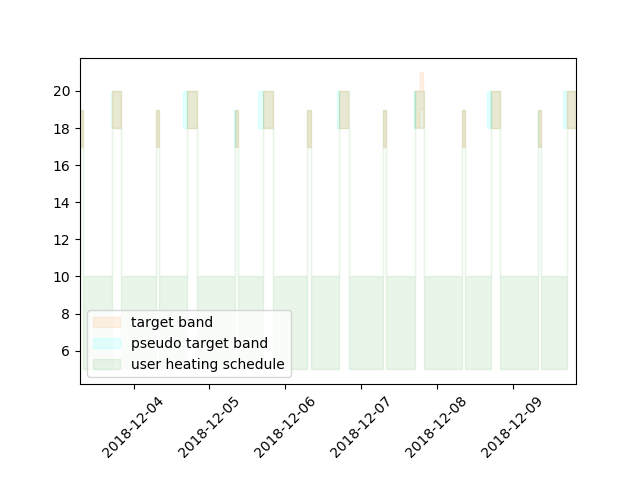

In [26]:
# let's look where there is an override

# get the user heating schedule
df_uhs_dec = df_uhs[df_uhs["createdtimestamp"] == "2018-11-25T15:49:05+0000"]
df_uhs_dec = df_uhs_dec[df_uhs_dec["roomid"] == "Bedrooms0"]
hours = {month: i*24 for i, month in enumerate(["MONDAY", 
                                                "TUESDAY",
                                               "WEDNESDAY",
                                               "THURSDAY",
                                               "FRIDAY",
                                               "SATURDAY",
                                               "SUNDAY"])}
df_uhs_dec["hour_day"] = df_uhs_dec["day"].replace(hours)
df_uhs_dec["datetime"] = pd.Timestamp("3 Dec 2018")
df_uhs_dec["total_hours"] = df_uhs_dec["hour"] + df_uhs_dec["hour_day"]
df_uhs_dec["total_hours"] = df_uhs_dec["total_hours"].apply(lambda x: pd.Timedelta(hours=x))
df_uhs_dec["datetime"] = df_uhs_dec["datetime"] + df_uhs_dec["total_hours"]
df_uhs_dec = df_uhs_dec.sort_values("datetime")

# get the heating targets
period = ["3 Dec 2018", "10 Dec 2018"]
df2 = df_ht_selected.copy()
df2 = df2[(df2["timestamp"] >= period[0]) 
        & (df2["timestamp"] < period[1])]
df2 = df2.set_index("timestamp").sort_index()
df2 = df2.resample("1min").last().fillna(method="ffill")
df2 = df2.replace({5:None, 10: None})

# plot
plt.close()
plt.fill_between(df2.index, df2["min"], df2["max"],
            alpha=0.1, color="tab:orange", label="target band")
plt.fill_between(df2.index, df2["psmin"], df2["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band")
plt.fill_between(df_uhs_dec["datetime"], df_uhs_dec["min"], df_uhs_dec["max"],
            alpha=0.1, color="tab:green", label="user heating schedule", step="post")
plt.xticks(rotation=45)
plt.xlim([df2.index.min(), df2.index.max()])
plt.subplots_adjust(bottom=0.2)
plt.legend(loc="lower left")

As visible, in the case of an override, the heating targets are not the same as the user heating schedule